### Dependencies

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray #conda install scikit-image
from PIL import Image, ImageOps, ImageFilter #conda install pillow
import glob

2022-11-24 23:09:05.967958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Update below path to folder of IVC image screenshots

In [2]:
def get_images():
    images = []
    #for f in glob.iglob("C:/Users/austi/OneDrive/Documents/AI Project/ivc/*.jpg"):
    for f in glob.iglob("/Users/austingay/OneDrive/Documents/AI Project/ivc/*.jpg"):
        images.append(Image.open(f))
    
    output_images = add_padding(images)
    
    return output_images

### Add padding around the images

In [3]:
def add_padding(images):
    
    padded_images = []
    
    for image in images:
        image = image.convert("L")
        image = ImageOps.expand(image, border=5, fill='white')
        padded_images.append(image)
    
    return padded_images

### Crop the images to the max and min pixels in both the vertical and horizontal directions

In [4]:
def crop_images(images):
    
    cropped_images = []
    
    for image in images:
                
        edges = image_edges(image)
                
        im = edges.load()
        w, h = edges.size
        
        n_min_pixel = h
        n_max_pixel = 0
        m_min_pixel = w
        m_max_pixel = 0
                
        for m in range(0, w-1):
            for n in range(0, h-1):
                if im[m,n] != 0:
                    if n < n_min_pixel:
                        n_min_pixel = n
                    if n > n_max_pixel:
                        n_max_pixel = n
                    if m < m_min_pixel:
                        m_min_pixel = m
                    if m > m_max_pixel:
                        m_max_pixel = m
                else:
                    continue
        
        #Crop image using found values
                
        cropped_images.append(image.crop((m_min_pixel - 1, n_min_pixel - 1, m_max_pixel + 1, n_max_pixel + 1)))
        
    return cropped_images

### Function to filter image to find edges within the image. Produces an image containing only edges

In [5]:
def image_edges(image):
            
    t = threshold_image(image, threshold=100)
        
    edges = t.filter(ImageFilter.Kernel((3,3),(-1,-1,-1,-1,8,-1,-1,-1,-1),1,0))
        
    edges = remove_border(edges)
    
    return edges

### Function to binarize an image using thresholding

In [6]:
def threshold_image(image, threshold):
    
    t = image.point( lambda p: 255 if p > threshold else 0 )
    
    return t

### Function to remove border of image. Strange effect when finding edges of an image

In [7]:
def remove_border(image):

    pix = image.load()

    for i in range(0, image.size[0]):
        pix[i,0] = 0
        pix[i, image.size[1]-1] = 0
    for j in range(0, image.size[1]):
        pix[0,j] = 0
        pix[image.size[0]-1, j] = 0
        
    return image

### Resize the images to the same dimensions

In [8]:
def resize_images(images, size):
    
    resized_images = []
    
    for image in images:
        image = image.resize(size)
        resized_images.append(image)
        
    return resized_images

### Enhance the images with smoothing and edge enhancing filters

In [9]:
def enhance_images(images):
    
    enhanced_images = []
    
    for image in images:
        image = image.filter(ImageFilter.SMOOTH)
        image = image.filter(ImageFilter.EDGE_ENHANCE)
        #image = image.filter(ImageFilter.SHARPEN)
        #image = image.filter(ImageFilter.SMOOTH)
        
        image = threshold_image(image, threshold=150)
        
        enhanced_images.append(image)
    
    return enhanced_images
    

### Function to implement all of the previous functions and transformations on the images

In [10]:
def format_images(images, size):
    
    formatted_images = []
    
    images = crop_images(images)
    
    images = resize_images(images, size)
    
    images = enhance_images(images)
    
    for image in images:
        formatted_images.append(np.asarray(image))
    
    return np.array(formatted_images)

### Train the SOM

In [11]:
def train_SOM(SOM, training_data, epochs = 10, learning_rate = 0.5, radius_sq = 1, lr_decay = 0.1, r_decay = 0.1):
    learning_rate_0 = learning_rate
    radius_sq_0 = radius_sq
    for epoch in range(epochs):
        for data in training_data:
            x,y = bestMatchingUnit(SOM, data)
            SOM = update_weights(SOM, data, learning_rate, radius_sq, (x,y))
        learning_rate = learning_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_sq_0 * np.exp(-epoch * r_decay)         
    return SOM

### Function to update the weight nodes of the SOM

In [12]:
def update_weights(SOM, data, learning_rate, radius_sq, BMU, step = 3):
    x,y = BMU
    
    if radius_sq < 1e-3:
        SOM[x,y] += learning_rate * (data - SOM[x,y])
        return SOM
    
    for i in range(max(0, x - step), min(SOM.shape[0], x + step)):
        for j in range(max(0, y - step), min(SOM.shape[1], y + step)):
            dist_sq = np.square(i - x) + np.square(j - y)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j] += learning_rate * dist_func * (data - SOM[i,j])   
    return SOM    

### Function that finds the best matching node to the input data

In [13]:
def bestMatchingUnit(SOM, data):
    # dist = (np.square(SOM - data)).sum(axis=2)
    dist = np.sqrt(np.sum((SOM - data)** 2,axis=2))
    return np.unravel_index(np.argmin(dist), dist.shape)

### Displays the SOM

In [14]:
def print_map(SOM, dim, image_size):
    
    %matplotlib tk
    
    fig, ax = plt.subplots(dim[0],dim[1])
    
    for i in range(0, dim[0]):
        for j in range(0, dim[1]):
            ax[i,j].imshow(SOM[i][j].reshape(image_size[1], image_size[0]), cmap='gray')
            ax[i,j].axis('off')
    

### Call Function to obtain images from folder

In [15]:
input_images = get_images()

### Define the image sized to be used when resizing images

In [16]:
image_size = (40,50)

### Call function to format and enhance images

In [17]:
images = format_images(input_images, image_size)

### Reshape images into 1d array

In [19]:
images = images.reshape(images.shape[0], images.shape[1] * images.shape[2]).astype(float)

In [20]:
images

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

### Display Raw Image

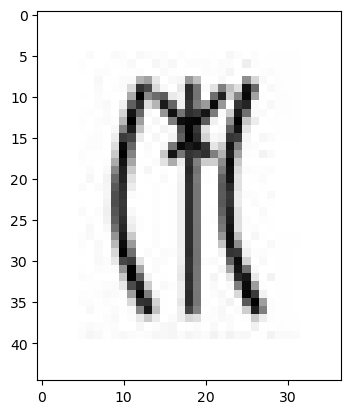

In [22]:
plt.imshow(np.asarray(input_images[83]), cmap='gray')

### Display image after image transformations

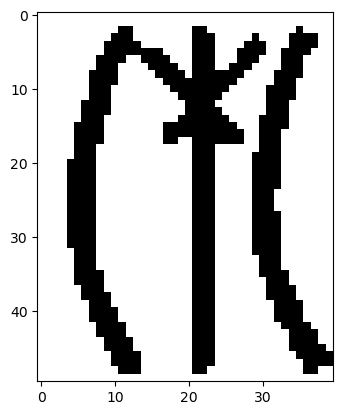

In [23]:
plt.imshow(images[83].reshape(image_size[1], image_size[0]), cmap='gray')

### Create initial SOM

In [33]:
rand = np.random.RandomState(4)

In [34]:
n = images.shape[0] #samples
m = images.shape[1] #features
dim = (10,10)
SOM = rand.randint(0, 255, (dim[0], dim[1], m)).astype(float)

### Train SOM using Images

In [35]:
SOM = train_SOM(SOM, images, epochs = 1000)

### Print the Final Result

In [36]:
print_map(SOM, dim, image_size)